# Exploratory Analysis of Spatial Data: Visualizing Spatial Autocorrelation with `splot` and `esda`

1. Imports
2. Load Example data
3. Assessing Global Spatial Autocorrelation
4. Visualizing Local Autocorrelation Statistics with `splot`
5. Combined visualizations: Moran Local Scatterplot, LISA clustermap and Choropleth map

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pysal as ps
import libpysal.api as lp
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

from libpysal import examples

from IPython.display import Image

## Example Data

First, we will load the Guerry.shp data from `examples` in `libpysal`.

In [2]:
link_to_data = examples.get_path('Guerry.shp')
df = gpd.read_file(link_to_data)

For this example we will focus on the Donatns (charitable donations per capita) variable. We will calculate Contiguity weights `w` with `ps.queen_from_shapefile()`. Then we transform our weights to be row-standardized.

In [3]:
y = df['Donatns'].values
w = lp.Queen.from_dataframe(df)
w.transform = 'r'

## Assessing Global Spatial Autocorrelation

We calculate Moran's I. A test for global autocorrelation for a continuous attribute.

In [4]:
from esda.moran import Moran

w = lp.Queen.from_dataframe(df)
moran = Moran(y, w)
moran.I

0.3533613255848606

Our value for the statistic is interpreted against a reference distribution under the null hypothesis of complete spatial randomness. PySAL uses the approach of random spatial permutations.

In [5]:
from importlib import reload
from splot._viz_esda_mpl import plot_moran
reload(splot._viz_esda_mpl)

<module 'splot._viz_esda_mpl' from '/Users/steffie/code/splot/splot/_viz_esda_mpl.py'>

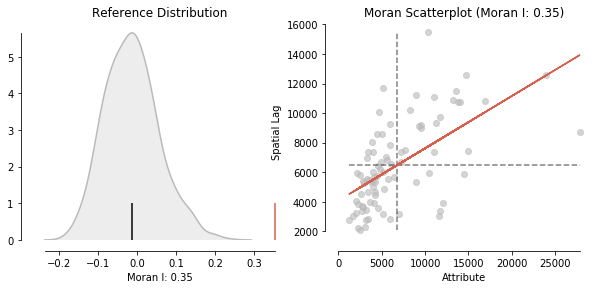

In [6]:
plot_moran(moran, zstandard=False, figsize=(10,4))
plt.show()

Our observed value is statistically significant:

In [7]:
moran.p_sim

0.001

## Visualizing Local Autocorrelation with splot - Hot Spots, Cold Spots and Spatial Outliers

In addition to visualizing Global autocorrelation statistics, splot has options to visualize local autocorrelation statistics. We compute the local Moran `m`. Then, we plot the spatial lag and the Donatns variable in a Moran Scatterplot.

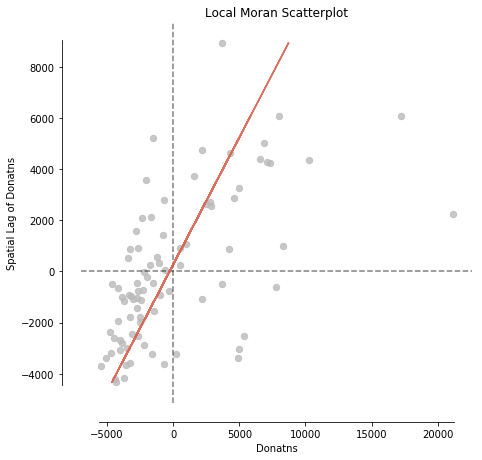

In [8]:
from splot.esda import moran_loc_scatterplot
from esda.moran import Moran_Local
reload(splot.esda)
moran_loc = Moran_Local(y, w)
moran_loc_scatterplot(moran, xlabel='Donatns', ylabel='Spatial Lag of Donatns',
      title='Local Moran Scatterplot', figsize=(7,7))
plt.show()

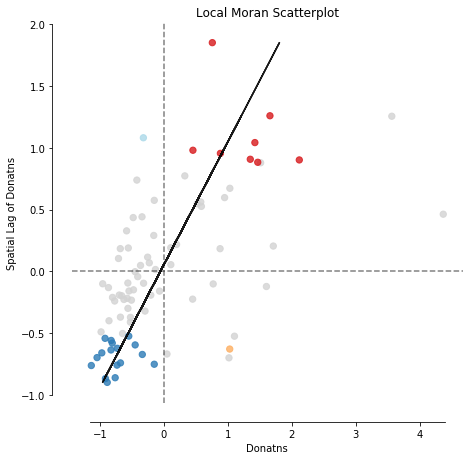

In [9]:
m = Moran_Local(y, w)
moran_loc_scatterplot(m, xlabel='Donatns', ylabel='Spatial Lag of Donatns',
                 title='Local Moran Scatterplot', p=0.05)
plt.show()

We can distinguish the specific type of local spatial autocorrelation in High-High, Low-Low, High-Low, Low-High.
Where the upper right quadrant displays HH, the lower left, LL, the upper left LH and the lower left HL.

These types of local spatial autocorrelation describe similarities or dissimilarities between a specific polygon with its neighbouring polygons. The upper left quadrant for example indicates that polygons with low values are surrounded by polygones with high values (LH). The lower right quadrant shows polygons with high values surrounded by neighbors with low values (HL). This indicates an association of dissimilar values.

Let's now visualize the areas we found to be significant on a map:

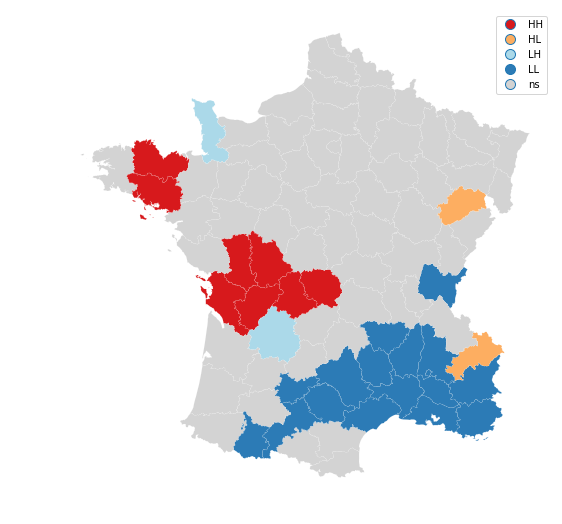

In [10]:
from splot.esda import lisa_cluster

lisa_cluster(moran_loc, df, p=0.05, figsize = (9,9))
plt.show()

# Combined visualizations

Often, it is easier to asses once statistical results or interpret these results comparing different visualizations.
Here we for example look at a static visualization of a Moran Scatterplot, LISA cluster map and choropleth map.

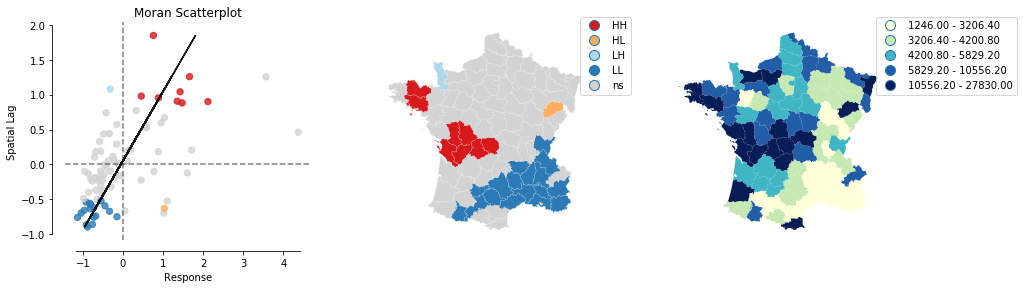

In [11]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(m, df, 'Donatns')
plt.show()

/Users/steffie/code/geopandas/geopandas/plotting.py:385: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


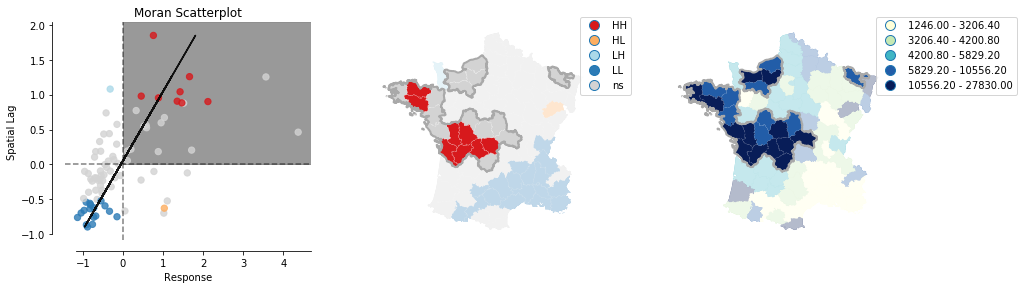

In [12]:
plot_local_autocorrelation(m, df, 'Donatns', quadrant=1)
plt.show()

## Bivariate Moran

What happens now if we are not only assessing the relation of a variable over space, but two variables over space?

In [13]:
from esda.moran import Moran_BV
from splot.esda import plot_moran_bv_simulation, moran_bv_scatterplot, plot_moran_bv

In [14]:
x = df['Suicids'].values
moran_bv = Moran_BV(x, y, w)

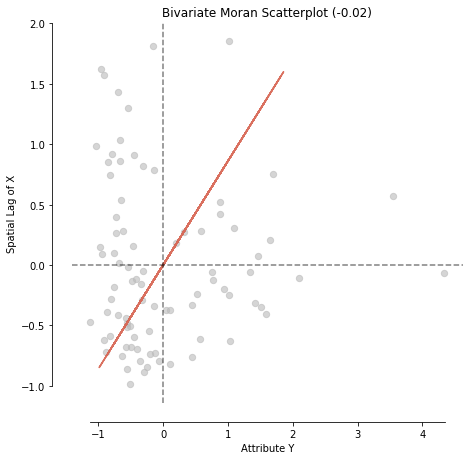

In [15]:
moran_bv_scatterplot(moran_bv)
plt.show()

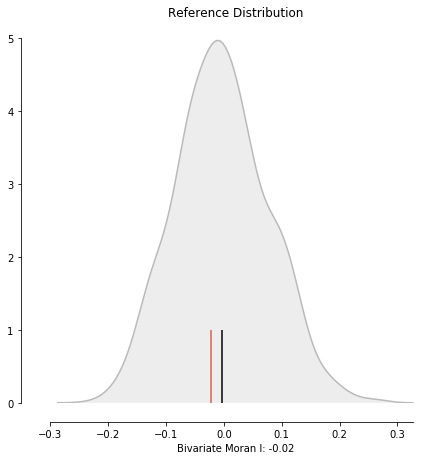

In [16]:
plot_moran_bv_simulation(moran_bv)
plt.show()

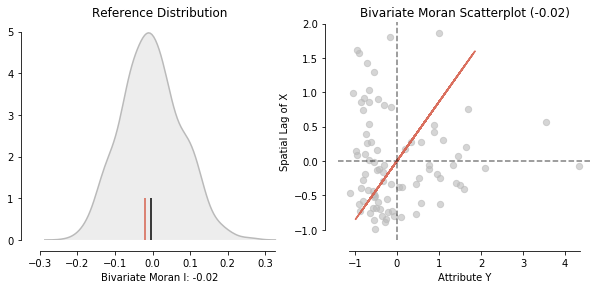

In [18]:
plot_moran_bv(moran_bv)
plt.show()